In [1]:
import sys, os

from torchvision.models import vit_b_16
import torch.nn as nn
import torch

from surgeon_pytorch import Extract, get_nodes

from PIL import Image
import torchvision.transforms as transforms
import os

import numpy as np

from matplotlib import pyplot as plt
import cv2

from captum.attr import LayerGradCam, LayerAttribution



In [2]:
external_repo_path = os.path.abspath('external/transformer_explainability')
if external_repo_path not in sys.path:
    sys.path.append(external_repo_path)

In [3]:
model = vit_b_16()
model.heads.head = nn.Linear(768,2)
model.load_state_dict(torch.load("logs/dfr_model.pth", map_location=torch.device('cpu'), weights_only=False))

<All keys matched successfully>

In [4]:
from external.transformer_explainability.baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from external.transformer_explainability.baselines.ViT.ViT_explanation_generator import LRP

model2 = vit_LRP(pretrained=True)



In [5]:
attribution_generator = LRP(model)


In [54]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def tensorize(img_path):
    image = Image.open(img_path).convert('RGB')
    return preprocess(image)


def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())



    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

In [7]:
img = tensorize('notebooks/data/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg')
img.shape

torch.Size([1, 3, 224, 224])

In [8]:
model.encoder.layers[0].self_attention.dropout

0.0

In [9]:
out = model(img)

In [18]:
from LRP.LRP_multihead_attention import LRPMultiheadAttention

In [13]:
def swap_attn_block(block):
    embed_dim = 768
    num_heads = 12
    dropout = 0.0
    
    block.self_attention = LRPMultiheadAttention(embed_dim, num_heads, dropout=dropout)
    return block

    

In [14]:
for block in model.encoder.layers:
    swap_attn_block(block)   


In [16]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): LRPMultiheadAttention(
          (MultiHeadAttention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
    

In [33]:
checkpoint = torch.load("logs/dfr_model.pth", map_location=torch.device('cpu'), weights_only=False)
model2 = vit_LRP(pretrained=True, num_classes=2)


In [34]:
print(checkpoint.keys())


odict_keys(['class_token', 'conv_proj.weight', 'conv_proj.bias', 'encoder.pos_embedding', 'encoder.layers.encoder_layer_0.ln_1.weight', 'encoder.layers.encoder_layer_0.ln_1.bias', 'encoder.layers.encoder_layer_0.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_0.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_0.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_0.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_0.ln_2.weight', 'encoder.layers.encoder_layer_0.ln_2.bias', 'encoder.layers.encoder_layer_0.mlp.0.weight', 'encoder.layers.encoder_layer_0.mlp.0.bias', 'encoder.layers.encoder_layer_0.mlp.3.weight', 'encoder.layers.encoder_layer_0.mlp.3.bias', 'encoder.layers.encoder_layer_1.ln_1.weight', 'encoder.layers.encoder_layer_1.ln_1.bias', 'encoder.layers.encoder_layer_1.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_1.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_1.self_attention.out_proj.weight', 'encoder.la

In [35]:
new_checkpoint = {}

for k, v in checkpoint.items():
        new_key = k
        new_key = new_key.replace('class_token', 'cls_token')
        new_key = new_key.replace('conv_proj', 'patch_embed.proj')
        new_key = new_key.replace('encoder.pos_embedding', 'pos_embed')
        new_key = new_key.replace('encoder.ln.weight', 'norm.weight')
        new_key = new_key.replace('encoder.ln.bias', 'norm.bias')
        new_key = new_key.replace('heads.head.weight', 'head.weight')
        new_key = new_key.replace('heads.head.bias', 'head.bias')

        new_key = new_key.replace('encoder.layers.encoder_layer_', 'blocks.')
        new_key = new_key.replace('.ln_1', '.norm1')
        new_key = new_key.replace('.ln_2', '.norm2')
        new_key = new_key.replace('.self_attention.in_proj_weight', '.attn.qkv.weight')
        new_key = new_key.replace('.self_attention.in_proj_bias', '.attn.qkv.bias')
        new_key = new_key.replace('.self_attention.out_proj.weight', '.attn.proj.weight')
        new_key = new_key.replace('.self_attention.out_proj.bias', '.attn.proj.bias')
        new_key = new_key.replace('.mlp.0', '.mlp.fc1')
        new_key = new_key.replace('.mlp.3', '.mlp.fc2')
        
        new_checkpoint[new_key] = v
        


In [36]:
model2.load_state_dict(new_checkpoint)

<All keys matched successfully>

In [41]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

In [40]:
attribution_generator = LRP(model2)


In [39]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam


def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())


    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis



In [55]:
image = tensorize('notebooks/data/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg')


In [56]:
model2(image.unsqueeze(0))

tensor([[-4.1998,  4.7300]], grad_fn=<AddmmBackward0>)

tensor([[-4.1998,  4.7300]], grad_fn=<AddmmBackward0>)


AssertionError: Torch not compiled with CUDA enabled

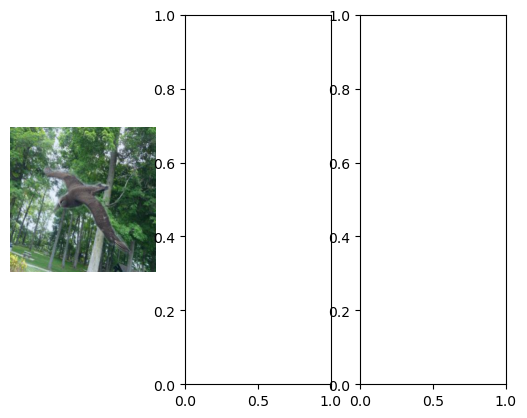

In [59]:

image_np = image.permute(1, 2, 0).numpy()
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image_np);
axs[0].axis('off');

output = model2(image.unsqueeze(0))
print(model2(image.unsqueeze(0)))
# cat - the predicted class
cat = generate_visualization(image)

# dog 
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(image, class_index=1)


axs[1].imshow(cat);
axs[1].axis('off');
axs[2].imshow(dog);
axs[2].axis('off');
